## Canny 算法从头实现

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
img = plt.imread("D:/cv作业/image-alignment/football.jpg")
img.shape

(300, 281)

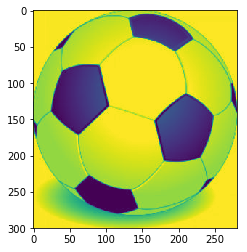

In [27]:
plt.imshow(img)

In [28]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

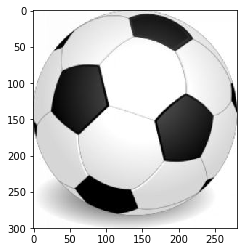

In [29]:
plt.imshow(img_rgb)

In [30]:
img_rgb.shape

(300, 281, 3)

In [31]:
def rgb2gray(rgb):
    '''
    图像灰度化
    1、基本公式：Gray(i,j) = [R(i,j) + G(i,j) + B(i,j)] / 3
    根据人眼对颜色的感知程度不同，衍生出第二个公式：
    Gray(i,j) = 0.299 * R(i,j) + 0.587 * G(i,j) + 0.114 * B(i,j)
    参考： https://my.oschina.net/wujux/blog/1797987
    '''
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [32]:
gray = rgb2gray(img_rgb)

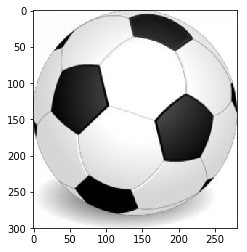

In [33]:
plt.imshow(gray, cmap="gray")

### Step 1. 高斯滤波

**高斯滤波原理：**

**如何产生一个高斯模板：**

In [16]:
sigma1 = sigma2 = 1
gau_sum = 0

gaussian = np.zeros([5, 5])

for i in range(5):
    for j in range(5):
        gaussian[i, j] = math.exp(-1/2 * (np.square(i-3)/np.square(sigma1)
                                         + (np.square(j-3)/np.square(sigma2)))) / (2*math.pi*sigma1*sigma2)
        gau_sum += gau_sum + gaussian[i, j]

In [17]:
gaussian

array([[1.96412803e-05, 2.39279779e-04, 1.07237757e-03, 1.76805171e-03,
        1.07237757e-03],
       [2.39279779e-04, 2.91502447e-03, 1.30642333e-02, 2.15392793e-02,
        1.30642333e-02],
       [1.07237757e-03, 1.30642333e-02, 5.85498315e-02, 9.65323526e-02,
        5.85498315e-02],
       [1.76805171e-03, 2.15392793e-02, 9.65323526e-02, 1.59154943e-01,
        9.65323526e-02],
       [1.07237757e-03, 1.30642333e-02, 5.85498315e-02, 9.65323526e-02,
        5.85498315e-02]])

In [18]:
# normalize

gaussian = gaussian / gau_sum

In [19]:
gaussian

array([[1.17168036e-09, 1.42739889e-08, 6.39715798e-08, 1.05471304e-07,
        6.39715798e-08],
       [1.42739889e-08, 1.73892783e-07, 7.79333385e-07, 1.28490353e-06,
        7.79333385e-07],
       [6.39715798e-08, 7.79333385e-07, 3.49272991e-06, 5.75853810e-06,
        3.49272991e-06],
       [1.05471304e-07, 1.28490353e-06, 5.75853810e-06, 9.49422426e-06,
        5.75853810e-06],
       [6.39715798e-08, 7.79333385e-07, 3.49272991e-06, 5.75853810e-06,
        3.49272991e-06]])

In [20]:
gray.shape

(300, 281)

In [21]:
W, H = gray.shape[0], gray.shape[1]
new_gray = np.zeros([W-5, H-5])

for i in range(W-5):
    for j in range(H-5):
        new_gray[i, j] = np.sum(gray[i:i+5, j:j+5]*gaussian) # 与高斯矩阵实现滤波      

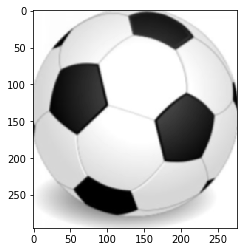

In [22]:
plt.imshow(new_gray, cmap="gray")

### Step 2. 计算梯度

In [34]:
new_gray.shape

(295, 276)

In [44]:
W1, H1 = new_gray.shape
dx = np.zeros([W1-1, H1-1])
dy = np.zeros([W1-1, H1-1])
d = np.zeros([W1-1, H1-1])
theta = np.zeros([W1-1, H1-1])

for i in range(W1-1):
    for j in range(H1-1):
        dx[i, j] = new_gray[i, j+1] - new_gray[i, j]
        dy[i, j] = new_gray[i+1, j] - new_gray[i, j]
        d[i, j] = np.sqrt(np.square(dx[i, j]) + np.square(dy[i, j])) # 图像梯度幅值作为图像强度值
        theta[i, j] = math.atan(dx[i, j] / (dy[i, j] + 0.000000001)) # 计算 slope θ

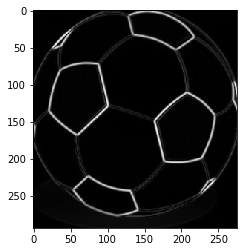

In [47]:
plt.imshow(d, cmap='gray')

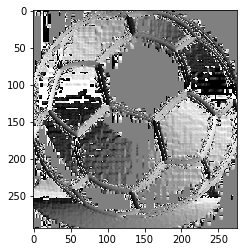

In [46]:
plt.imshow(theta, cmap='gray')

### Step 3. 非极大值抑制

In [48]:
W2, H2 = d.shape
NMS = np.copy(d)
NMS[0, :] = NMS[W2-1, :] = NMS[:,0] = NMS[:, H2-1] = 0
for i in range(1, W2-1):
    for j in range(1, H2-1):
        if d[i, j] == 0:
            NMS[i, j] =0
        else:
            gradX = dx[i, j]
            gradY = dy[i, j]
            gradTemp = d[i, j]
            
            # 如果 Y 方向幅度值较大
            if np.abs(gradY) > np.abs(gradX):
                weight = np.abs(gradX) / np.abs(gradY)
                grad2 = d[i-1, j]
                grad4 = d[i+1, j]
                # 如果 x，y 方向符号相同
                if gradX * gradY > 0:
                    grad1 = d[i-1, j-1]
                    grad3 = d[i+1, j+1]
                # 如果 x，y 方向符号相反
                else:
                    grad1 = d[i-1, j+1]
                    grad3 = d[i+1, j-1]
            # 如果 X 方向幅度值较大
            else:
                weight = np.abs(gradY) / np.abs(gradX)
                grad2 = d[i, j-1]
                grad4 = d[i, j+1]
                # 如果 x，y 方向符号相同
                if gradX * gradY > 0:
                    grad1 = d[i+1, j-1]
                    grad3 = d[i-1, j+1]
                # 如果 x，y 方向符号相反
                else:
                    grad1 = d[i-1, j+1]
                    grad3 = d[i+1, j+1]
            
            gradTemp1 = weight * grad1 + (1-weight) * grad2
            gradTemp2 = weight * grad3 + (1-weight) * grad4
            
            if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                NMS[i, j] = gradTemp
            else:
                NMS[i, j] = 0          

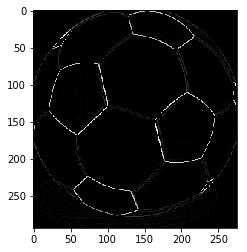

In [49]:
plt.imshow(NMS, cmap = "gray")

### Step 4. 双阈值算法检测

In [56]:
W3, H3 = NMS.shape
DT = np.zeros([W3, H3])
# 定义高低阈值
TL = 0.1 * np.max(NMS)
TH = 0.3 * np.max(NMS)

for i in range(1, W3-1):
    for j in range(1, H3-1):
        if(NMS[i, j] < TL):
            DT[i, j] = 0
        elif(NMS[i, j] > TH):
            DT[i, j] = 1
        elif((NMS[i-1, j-1:j+1] < TH).any() or (NMS[i+1, j-1:j+1]).any()
             or (NMS[i, [j-1, j+1]] < TH).any()):
            DT[i, j] = 1

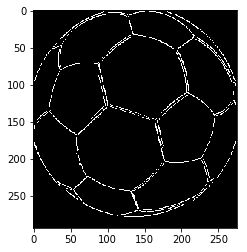

In [58]:
# 双阈值：0.1*max, 0.3*max

plt.imshow(DT, cmap="gray")

In [59]:
W3, H3 = NMS.shape
DT = np.zeros([W3, H3])
# 定义高低阈值
TL = 0.2 * np.max(NMS)
TH = 0.3 * np.max(NMS)

for i in range(1, W3-1):
    for j in range(1, H3-1):
        if(NMS[i, j] < TL):
            DT[i, j] = 0
        elif(NMS[i, j] > TH):
            DT[i, j] = 1
        elif((NMS[i-1, j-1:j+1] < TH).any() or (NMS[i+1, j-1:j+1]).any()
             or (NMS[i, [j-1, j+1]] < TH).any()):
            DT[i, j] = 1

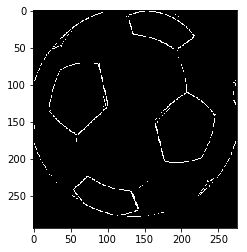

In [60]:
# 双阈值：0.2*max, 0.3*max

plt.imshow(DT, cmap="gray")

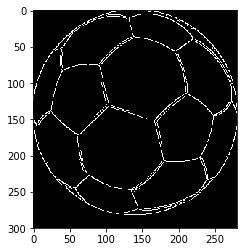

In [73]:
# opencv 边缘检测的结果

cv_edges = cv2.Canny(img_rgb, 100, 200)
plt.imshow(cv_edges, cmap="gray")

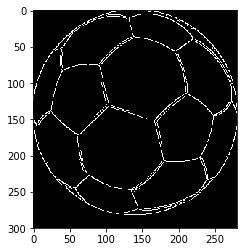

In [74]:
# skimage 边缘检测的结果

from skimage import feature

sk_edges = feature.canny(img)
plt.imshow(cv_edges, cmap="gray")

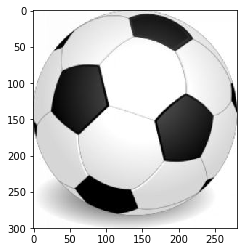

In [77]:
plt.imshow(img_rgb)